# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

('This image is:', <type 'numpy.ndarray'>, 'with dimesions:', (540, 960, 3))


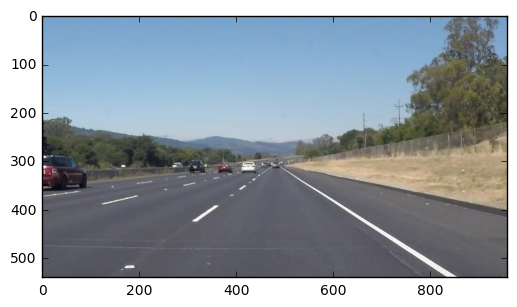

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [5]:
import math

imshape = (0, 0, 0)

canny_low_threshold = 50
canny_high_threshold = 150
blur_kernel_size = 5

# Define the Hough transform parameters
rho = 1               # distance resolution in pixels of the Hough grid
theta = 1*np.pi/180   # angular resolution in radians of the Hough grid
threshold = 30        # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 150    # maximum gap in pixels between connectable line segments

filter_threshold_low = 25   # degree
filter_threshold_high = 70  # degree

low_pass_weight = 0.5
prev_left_line = []
prev_right_line = []

# Define mask parameters
offset_from_left = 100
offset_from_right = 10
offset_from_bottom = 0
trapezoid_height_ratio = 0.4
trapezoid_width_ratio1 = 1
trapezoid_width_ratio2 = 0.1

# Normal masking algorithm
lower_yellow = np.array([0, 65, 150])
upper_yellow = np.array([179, 255, 255])
lower_white = np.array([0, 0, 205])
upper_white = np.array([179, 255, 255])

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def fit_line_LSE(points):
    # get mean, min and max of y1 and y2 for the left line
    point_mean = np.mean(np.array(points), axis = 0)[0]
    point_max = np.max(np.array(points), axis=0)[0]
    point_min = np.min(np.array(points), axis=0)[0]
    y_max = imshape[0] #max(point_max[1], point_max[3])
    y_min = min(point_min[1], point_min[3])
    x_mean = (point_mean[0] + point_mean[2]) / 2
    y_mean = (point_mean[1] + point_mean[3]) / 2

    nom = denom = 0
    for point in points:
        for x1, y1, x2, y2 in point:
            nom += (x1-x_mean)*(y1-y_mean)
            nom += (x2-x_mean)*(y2-y_mean)
            denom += (x1-x_mean)*(x1-x_mean)
            denom += (x2-x_mean)*(x2-x_mean)
    m_lse = nom/denom
    b_lse = y_mean - m_lse*x_mean
    x1 = int((y_min - b_lse)/m_lse)
    x2 = int((y_max - b_lse)/m_lse)

    return [x1, y_min, x2, y_max]

def group_lines(lines):
    left_new = []
    right_new = []
    left_lines = []
    right_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            rho = (y2 - y1) / (x2 - x1)
            if rho < 0 :
                left_lines.append(line)
            else:
                right_lines.append(line)

    if len(left_lines) > 0:
        left_new = [fit_line_LSE(left_lines)]
    if len(right_lines) > 0:
        right_new = [fit_line_LSE(right_lines)]
    return [np.array(left_new), np.array(right_new)]

def filter_lines(lines, rho_low, rho_high):
    lines_new = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            rho = abs(math.atan2(y2 - y1, x2 - x1) * 180 / np.pi)
            if rho > rho_low and rho < rho_high :
                lines_new.append(line)
    return lines_new

def low_pass_filter(lines):
    global prev_left_line
    global prev_right_line
    left_line = lines[0]
    right_line = lines[1]
    if len(prev_left_line) > 0 and len(left_line) > 0:
        left_line =  np.floor(prev_left_line*low_pass_weight + left_line*(1-low_pass_weight))

    if len(prev_right_line) > 0 and len(right_line) > 0:
        right_line =  np.floor(prev_right_line*low_pass_weight + right_line*(1-low_pass_weight))
    left_line = left_line.astype(int)
    prev_left_line = left_line
    right_line = right_line.astype(int)
    prev_right_line = right_line
    return [left_line, right_line]

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    lines = filter_lines(lines, filter_threshold_low, filter_threshold_high)

    lines = group_lines(lines)

    lines = low_pass_filter(lines)

    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if len(lines) > 0:
        draw_lines(line_img, lines, [255, 0, 0], 8)

    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, alpha=0.8, beta=1., gamma=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * alpha + img * beta + gamma
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)



In [6]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    global imshape
    imshape = image.shape

    # Convert BGR to HSV
    # HSV color space is more robust to light luminance
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    gray = hsv[:, :, 2]

    # Color threshold to retain yellow and white
    # Also make it more robust against light condition
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask_white = cv2.inRange(hsv, lower_white, upper_white)
    gray_white = cv2.bitwise_and(gray, gray, mask = mask_white)
    gray_yellow = cv2.bitwise_and(gray, gray, mask = mask_yellow)
    gray = gray_yellow + gray_white

    # dilate to make lines look thicker
    gray = cv2.dilate(gray, np.ones((7, 7)))

    # smooth image
    blur = gaussian_blur(gray, blur_kernel_size)

    # apply canny edge detection
    edges = canny(blur, canny_low_threshold, canny_high_threshold)

    # This time we are defining a four sided polygon to mask
    height = trapezoid_height_ratio * imshape[0]
    width_large = trapezoid_width_ratio1 * imshape[1]
    width_small = trapezoid_width_ratio2 * imshape[1]

    vertices = np.array([[(offset_from_left, imshape[0] - offset_from_bottom ),
                          (width_large/2 - width_small/2, imshape[0] - height),
                          (width_large/2 + width_small/2, imshape[0] - height),
                          (width_large - offset_from_right, imshape[0] - offset_from_bottom)]], dtype=np.int32)

    # mask out undesired regions
    masked_edges = region_of_interest(edges, vertices)

    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    # cv2.polylines(line_img, vertices, 1, [255, 255, 0], 2)
    line_img = weighted_img(line_img, image)

    return line_img


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

saved result in /hamidb/applications/udacity-carnd/repo/CarND-Udacity/CarND-LaneLines-P1-solution/test_images/solidWhiteCurve_out.png
saved result in /hamidb/applications/udacity-carnd/repo/CarND-Udacity/CarND-LaneLines-P1-solution/test_images/solidWhiteRight_out.png
saved result in /hamidb/applications/udacity-carnd/repo/CarND-Udacity/CarND-LaneLines-P1-solution/test_images/solidYellowCurve_out.png
saved result in /hamidb/applications/udacity-carnd/repo/CarND-Udacity/CarND-LaneLines-P1-solution/test_images/solidYellowCurve2_out.png
saved result in /hamidb/applications/udacity-carnd/repo/CarND-Udacity/CarND-LaneLines-P1-solution/test_images/solidYellowLeft_out.png
saved result in /hamidb/applications/udacity-carnd/repo/CarND-Udacity/CarND-LaneLines-P1-solution/test_images/whiteCarLaneSwitch_out.png


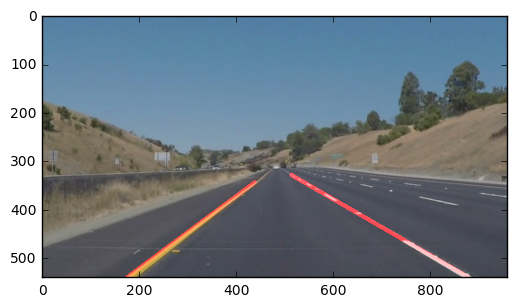

In [7]:
import os
import fnmatch

os.listdir("test_images/")

test_dir = os.getcwd() + '/test_images'
for file in os.listdir(test_dir):
    if not fnmatch.fnmatch(file, "*.jpg"):
        continue
    filename = os.path.join(test_dir, file)
    image = mpimg.imread(filename)
    result  = process_image(image)
    plt.imshow(result)
    filename = filename.split('.')[0] + "_out.png"
    print("saved result in %s" % filename)
    plt.savefig(filename, format='png')
    prev_right_line = []
    prev_left_line = []


run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [9]:
prev_right_line = []
prev_left_line = []

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 60.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.91 s, sys: 785 ms, total: 4.69 s
Wall time: 4.04 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
prev_right_line = []
prev_left_line = []

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:12<00:00, 54.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12.6 s, sys: 2.5 s, total: 15.1 s
Wall time: 13 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### Pilepine description
The current pipeline has the following steps:
1. Color space conversion to HSV space that is more robust agains lighting conditions
2. Color thresholding to discard objects with irrelevant color 
3. As the color selection step makes the lines look thinner, dilation is used to make them bigger again.
4. Gaussian smooth filter is applied to reject noise
5. Canny edge detection is used to find contours
6. Mask is applied to detect lines in region of interest
7. Hough transform applied to detect lines
8. Early filter is applied to reject lines with wrong orientations
9. Lines are grouped into one single line by minimizing square error (Regression)
10. Fore video sequence, simple low pass filter is applied to remove jitters 

### Drawbacks and sources of improvement
1. This current algorithm are prone to error when being used in different light conditions like driving at night. This is because color selection is used to discard irrelevant colors. A better color segmentation algorithm can be a possible solution. 
2. Grouping lines into one single detection is not so robust to outliers as LSE has zero breakdown point. More robust estimation schemes such as RANSAC can be used.
3. Simple average filtering can be replaced by a more dynamic aware filter such as Kalman filter. This will more intelligently remember history of states. 
4. Better feature extraction technique can be replace with Canny edge detector
5. Change in lines' color must be addressed better fault tolerance.
6. This algorithm is not robust against more complex lane lines like curved lines and so. 


## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
# Better result with this mask 
# for the challenge sequence because it's a different car
offset_from_left = 170
offset_from_right = 50
offset_from_bottom = 50
trapezoid_height_ratio = 0.4
trapezoid_width_ratio1 = 1
trapezoid_width_ratio2 = 0.08

prev_right_line = []
prev_left_line = []

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:08<00:00, 28.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 8.38 s, sys: 1.4 s, total: 9.78 s
Wall time: 9.58 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))